In [1]:
# Load Packages/Functions and set Path/Date

import os
from tkinter import filedialog
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from bioinfokit import analys, visuz

import mygene
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Function to remove rows with less than 5 counts per million
def below5(df):
    for i in range(df.shape[0]):
        if df.loc[i][1:].max() < 5:
            df.drop([i], inplace=True)
    return df

# function for selecting number of PCs for 80% Variance explained
def find80p(variance):
    count = 0
    i = 0
    while count < 0.80:
        count += variance[i]
        i += 1
    return i

# function to prepend a string to each list element
def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

# function to check for Total and % Missing
def nan_check(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total Null', '% Missing'])
    return missing_data

# function to find protein-transcripts that: correlate, anti-correlate, or don't correlate
def getQuntCorr(X):
    X_corr = []
    for i in range(X.shape[0]):
        X_corr.append(X.iloc[i][i])
    d = {'Correlation': X_corr}
    df = pd.DataFrame(d, index=X.index)
    return df

# Set Path/Date 
Path = filedialog.askdirectory()
Date = pd.to_datetime('today').date()

# Transcriptomics

### To be ran in R via RUVSeq/edgeR

In [2]:
#Read newNormCounts table
R_df = pd.read_excel('/Users/wyssuser/Documents/BD2/Transcriptomics/BD_newNormCounts_Li_Data_02222024.xlsx')
print(R_df.shape)
R_df.head()

(23426, 17)


,EnsemblID,CTR1_apr,CTR2_apr,CTR3_apr,BD1_apr,BD2_apr,BD3_apr,BD4_apr,BD5_apr,BD6_apr,BD_1_feb,BD_2_feb,BD_3_feb,CTR_1_feb,CTR_2_feb,CTR_3_feb,CTR_4_feb
0,ENSG00000000003,504,571,519,540,572,595,544,578,622,602,492,517,568,487,501,519
1,ENSG00000000005,4,1,2,5,5,3,4,7,11,1,3,3,3,2,0,2
2,ENSG00000000419,371,303,327,313,286,305,296,328,283,308,368,319,347,279,314,322
3,ENSG00000000457,183,160,168,148,137,131,134,144,153,132,160,125,168,160,156,173
4,ENSG00000000460,129,157,143,124,134,140,124,133,144,117,138,146,146,137,151,139


In [3]:
# Create Dataframe from Ensemble ID list
mg = mygene.MyGeneInfo()
geneSymbol = mg.querymany(R_df.EnsemblID, scopes='ensembl.gene', fields='symbol', species='human')
gs_df = pd.DataFrame(geneSymbol)
gs_df.rename(columns={'query': 'EnsemblID', 'symbol': 'geneSymbol'}, inplace=True)
gs_df.drop(['_id', '_score','notfound'], axis=1, inplace=True)
gs_df.dropna(inplace=True)
gs_df.drop_duplicates(subset=['EnsemblID'], inplace=True)
gs_df.shape

1 input query terms found dup hits:	[('ENSG00000230373', 2)]
206 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130723', 'ENSG00000154537', 'ENSG00000161149', 'ENS


(20001, 2)

In [4]:
# Map EnsemblID to gene symbol
counts = pd.merge(gs_df, R_df, on = 'EnsemblID', how = 'left')
counts

,EnsemblID,geneSymbol,CTR1_apr,CTR2_apr,CTR3_apr,BD1_apr,BD2_apr,BD3_apr,BD4_apr,BD5_apr,BD6_apr,BD_1_feb,BD_2_feb,BD_3_feb,CTR_1_feb,CTR_2_feb,CTR_3_feb,CTR_4_feb
0,ENSG00000000003,TSPAN6,504,571,519,540,572,595,544,578,622,602,492,517,568,487,501,519
1,ENSG00000000005,TNMD,4,1,2,5,5,3,4,7,11,1,3,3,3,2,0,2
2,ENSG00000000419,DPM1,371,303,327,313,286,305,296,328,283,308,368,319,347,279,314,322
3,ENSG00000000457,SCYL3,183,160,168,148,137,131,134,144,153,132,160,125,168,160,156,173
4,ENSG00000000460,FIRRM,129,157,143,124,134,140,124,133,144,117,138,146,146,137,151,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,ENSG00000285278,TFAP2A-AS2,14,8,15,70,39,20,62,31,23,34,62,35,26,21,8,26
19997,ENSG00000285331,TCF12-DT,14,24,21,23,22,18,19,21,27,22,23,17,23,20,17,31
19998,ENSG00000285410,GABPB1-IT1,329,478,422,504,451,470,479,391,469,494,438,453,480,425,482,449
19999,ENSG00000285427,SOD2-OT1,5,6,7,3,8,5,12,4,9,6,3,7,11,9,9,13


In [20]:
# Agg counts naively on sum
aggCounts = counts.drop('EnsemblID', axis=1).groupby(['geneSymbol']).agg('sum')
aggCounts.to_excel('Cleaned_Counts.xlsx')
aggCounts.shape

(19963, 16)

In [43]:
# PCA/UMAP DF on Log2 Transformed Norm Counts
pcaUmap = aggCounts.T
pcaUmap['Condition'] = ['CTR', 'CTR', 'CTR', 'BD', 'BD', 'BD', 'BD', 'BD', 'BD', 'BD', 'BD', 
                           'BD', 'CTR', 'CTR', 'CTR', 'CTR']
X = pcaUmap.iloc[:,:-1].apply(lambda x: np.log2(x)).replace(-np.inf, np.nan).dropna(axis=1)
y = pcaUmap.Condition

# Build model
pca = PCA(n_components=min(X.shape))
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=y, 
                 labels={
                     '0': 'PC 1',
                     '1': 'PC 2',
                     'color': 'BD'},
                 #hover_name = Gpca.index,
                 title='Principal Component Analysis')
fig.show()
fig.write_image('Gene_PCA.pdf')

# UMAP on count data
print('\nGenerating UMAP')
umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.75, n_epochs=5000, 
               random_state=42)
umap_3d = UMAP(n_components=3, n_neighbors=15, min_dist=0.75, n_epochs=5000, 
               random_state=42)

proj_2d = umap_2d.fit_transform(X)
proj_3d = umap_3d.fit_transform(X)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=y,
    labels={
        0: 'UMAP Embedding 1',
        1: 'UMAP Embedding 2',
        'color': 'BD'},
    #hover_name=Gpca.index,
    title='Uniform Manifold Approximation & Projection'
)
fig_2d.update_traces(marker_size=10)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=y,
    labels={
        0: 'UMAP Embedding 1',
        1: 'UMAP Embedding 2',
        2: 'UMAP Embedding 3',
        'color': 'BD'},
    #hover_name=Gpca.index,
    title='Uniform Manifold Approximation & Projection'
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

fig_2d.write_image('Gene_UMAP.pdf')

### PCA nth component allows possibility to perform UMAP on PCs instead of count data
# select pcs for 80% variance explained
variance = pca.explained_variance_ratio_
pcs = find80p(variance)
npc = [x+1 for x in range(pcs)]
PC_str = 'PC '

# make PC_df Col labels
PCA_cols = prepend(npc, PC_str)
pca = PCA(n_components=pcs, svd_solver = 'auto')
Principal_components=pca.fit_transform(X)
pca_df = pd.DataFrame(data = Principal_components, columns = PCA_cols)
pca_df['Condition'] = list(y)

# UMAP on principle components
print('\nGenerating UMAP')
pcaFeatures = pca_df.iloc[:,:-1]

umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.75, n_epochs=5000, 
               random_state=42)
umap_3d = UMAP(n_components=3, n_neighbors=15, min_dist=0.75, n_epochs=5000, 
               random_state=42)

proj_2d = umap_2d.fit_transform(pcaFeatures)
proj_3d = umap_3d.fit_transform(pcaFeatures)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=pca_df.Condition,
    labels={
        0: 'UMAP Embedding 1',
        1: 'UMAP Embedding 2',
        'color': 'BD'},
    hover_name=pca_df.index,
    title='Uniform Manifold Approximation & Projection'
)
fig_2d.update_traces(marker_size=10)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=pca_df.Condition,
    labels={
        0: 'UMAP Embedding 1',
        1: 'UMAP Embedding 2',
        2: 'UMAP Embedding 3',
        'color': 'BD'},
    hover_name=pca_df.index,
    title='Uniform Manifold Approximation & Projection'
)
fig_3d.update_traces(marker_size=5)

fig_2d.show()
fig_3d.show()

fig_2d.write_image('Gene_PCA_UMAP.pdf')


Generating UMAP



Generating UMAP


# Proteomics
### To be ran via WASP3

In [44]:
# Load normalized/imputed as Pandas DataFrame
W_df = pd.read_csv('/Users/wyssuser/Documents/BD2/Forebrain/WASP3-1_Forebrain_Set1_Li/WASP3-1_Forebrain_Set1_Li_Li_Imputed_2024-02-22.csv')
W_df = W_df.drop(['Unnamed: 0', 'Annotated Sequence', 'File ID'], axis=1)
W_df = W_df.groupby(['Master Protein Accessions']).agg('median').reset_index()
print(W_df.shape)
W_df.head()

(6398, 8)


,Master Protein Accessions,131N,131C,132N,132C,133N,133C,134N
0,1070608,3.942416e+05,3.429835e+05,1.090390e+06,1.853147e+05,3.925681e+05,2.833491e+05,2.985446e+05
1,1070608; 125083,2.351148e+06,5.729074e+06,7.536286e+06,1.468147e+06,2.168436e+06,2.305241e+06,2.101078e+06
2,125083,3.936648e+05,6.812722e+05,1.279875e+06,2.895665e+05,4.204388e+05,3.846190e+05,3.958795e+05
3,A0A0B4J2D5,5.254492e+05,5.366493e+05,4.471064e+05,4.816720e+05,4.176854e+05,4.133077e+05,5.896070e+05
4,A0A1B0GTU1,6.926870e+05,9.726115e+05,6.321541e+05,8.708185e+05,5.857688e+05,1.115214e+06,1.139454e+06


# Multiomics

### Gene Ontology
#### To be ran with goVIZ

## Mapping

In [47]:
### Map Gene Symbol to Protein Accession
# read file
print('Mapping Gene Symbol to Protein Accessions')
RegulatedProteins = W_df
RegulatedProteins['geneSymbol'] = ''
RegulatedProteins['Master Protein Accessions'] = RegulatedProteins['Master Protein Accessions'].str.split('; ').str[0]

# rename Gene column and remove white space
UniProt = pd.read_excel('Uniprot.xlsx')
UniProt.rename(columns={'Entry': 'Master Protein Accessions', 'Gene Names': 'geneSymbol'}, inplace=True)
UniProt.drop(['Protein names'], axis = 1, inplace=True)
UniProt['geneSymbol'] = UniProt['geneSymbol'].str.split(' ').str[0]

# merge
mapped = pd.merge(UniProt, RegulatedProteins, on = 'Master Protein Accessions', how = 'right')

# clean
mapped.drop(['geneSymbol_y'], axis=1, inplace=True)
mapped.rename(columns={'geneSymbol_x': 'geneSymbol'},inplace=True)
mapped.dropna(inplace=True)
mapped.drop('Master Protein Accessions', axis=1, inplace=True)
mapped.set_index('geneSymbol', inplace=True)

print('\nComplete')

# Merge and export
PT = pd.merge(mapped, counts.drop('EnsemblID', axis=1), on='geneSymbol', how='inner').set_index('geneSymbol')
PT.to_excel(f'{Path}/{Date}_Forebrain_Protein_Transcript_Merged.xlsx')


Mapping Gene Symbol to Protein Accessions


## Correlation

In [53]:
# Normalize
object = StandardScaler()
zPT = object.fit_transform(PT)
zPT = pd.DataFrame(zPT, columns=PT.columns, index=PT.index)

,131N,131C,132N,132C,133N,133C,134N,CTR1_apr,CTR2_apr,CTR3_apr,...,BD4_apr,BD5_apr,BD6_apr,BD_1_feb,BD_2_feb,BD_3_feb,CTR_1_feb,CTR_2_feb,CTR_3_feb,CTR_4_feb
geneSymbol,,,,,,,,,,,,,,,,,,,,,
ZC3H11B,0.729437,0.555209,0.446410,1.005690,0.450232,1.594262,1.780863,-0.371087,-0.394320,-0.377692,...,-0.409658,-0.401409,-0.392540,-0.413956,-0.382486,-0.409759,-0.387790,-0.389488,-0.388934,-0.361200
UBE2L5,1.505875,0.104028,0.806880,1.165520,1.236429,0.995608,1.073441,-0.372320,-0.394834,-0.378929,...,-0.411601,-0.402246,-0.394096,-0.416526,-0.382737,-0.411959,-0.388284,-0.390264,-0.389930,-0.363275
RBM47,-0.597299,-0.390394,-0.583142,-0.390533,-0.717008,-0.383491,-0.442760,-0.359004,-0.375792,-0.366309,...,-0.389950,-0.390255,-0.324832,-0.409101,-0.366921,-0.396555,-0.360870,-0.376812,-0.372512,-0.355436
UBA6,0.122744,0.255547,0.168887,0.176403,0.117653,0.195536,0.033894,-0.072456,-0.107398,-0.092374,...,-0.119593,-0.109715,-0.098102,-0.114105,-0.125158,-0.113777,-0.107722,-0.114758,-0.107015,-0.090268
SHTN1,0.301931,-0.207865,-0.028193,0.348442,0.415284,0.541413,0.521735,-0.001435,0.111074,0.011558,...,-0.099330,0.031670,-0.020277,-0.033003,-0.028252,-0.031529,0.036758,-0.014644,-0.049287,-0.028472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WASF2,0.105238,-0.266781,0.086346,0.033000,0.346844,0.156582,0.073347,-0.134352,-0.138792,-0.114893,...,-0.064355,-0.112504,-0.151282,-0.087833,-0.062897,-0.042807,-0.114884,-0.103893,-0.103531,-0.098338
FAM169A,-0.132600,-0.298238,-0.169793,-0.125173,-0.102720,-0.007300,0.088240,-0.253213,-0.277750,-0.270543,...,-0.286970,-0.284564,-0.279175,-0.302297,-0.282065,-0.295327,-0.256400,-0.274370,-0.279202,-0.270582
MORC2,0.052767,-0.370657,-0.264614,-0.400467,0.073588,-0.260327,-0.144368,-0.075415,-0.081665,-0.112171,...,-0.150681,-0.077924,-0.122228,-0.126099,-0.149510,-0.153113,-0.098337,-0.106221,-0.142597,-0.145838


### Transcription Factor

<Figure size 3000x3000 with 0 Axes>

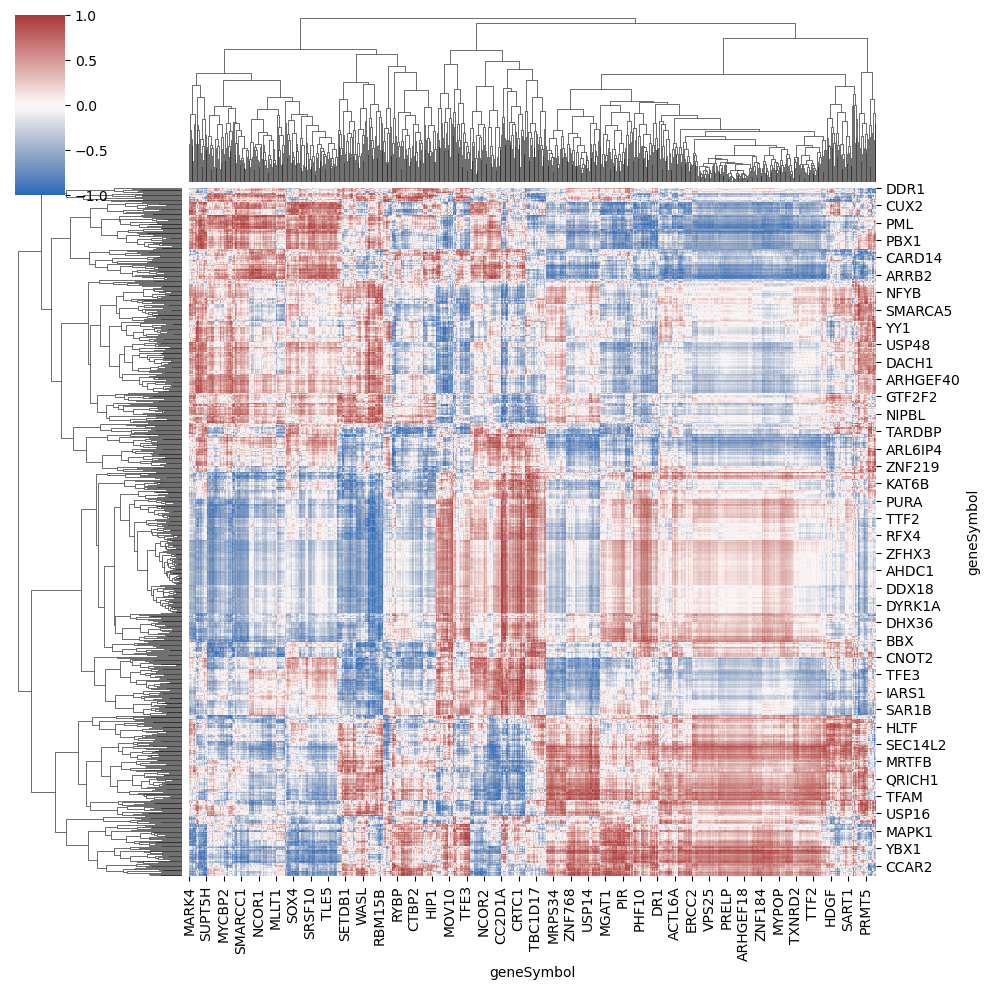

In [80]:
# Transcription Factor
tf = pd.read_excel('transcriptionFactorHu.xlsx')

# Clean tf database
tf.rename(columns={'Entry': 'Master Protein Accessions', 'Gene Names': 'geneSymbol'}, inplace=True)
tf.drop(['Entry Name', 'Master Protein Accessions'], axis = 1, inplace=True)
tf['geneSymbol'] = tf['geneSymbol'].str.split(' ').str[0]

# Isolate Transcription Factors
tf = tf.astype(str)
tf_list = '|'.join(list(tf.geneSymbol))
zPT_tf = zPT.loc[zPT.index.str.contains(tf_list, case=False, na=False)]
zPT_tf

# Split and Agg duplicates
zptf = zPT_tf.iloc[:,:7]
zttf = zPT_tf.iloc[:,7:]
zptf = zptf.groupby(['geneSymbol']).agg('mean')
zttf = zttf.groupby(['geneSymbol']).agg('mean')

# Rename columns for correlation
zptf.rename(columns={'131N': 'BD1', '131C': 'BD2', '132N': 'BD3', '132C': 'CTL1', '133N': 'CTL2', '133C': 'CTL3',
                  '134N': 'CTL4'}, inplace=True)
zttf.rename(columns={'CTR1_apr': 'CTL1', 'CTR_2_feb': 'CTL2', 'CTR3_apr': 'CTL3', 'CTR_4_feb': 'CTL4',
                  'BD1_apr': 'BD1', 'BD_2_feb': 'BD2', 'BD3_apr': 'BD3'}, inplace=True)
cols = ['BD1', 'BD2', 'BD3', 'CTL1', 'CTL2', 'CTL3', 'CTL4']
zttf = zttf[cols]

# Make correlation dataframe
hmtf = pd.concat([zptf.T, zttf.T], axis=1, keys=['zp', 'zt']).corr().loc['zp', 'zt']
hmtf.to_excel(f'{Path}/{Date}_Transcription_Factor_Correlation_Heatmap_Matrix.xlsx')

# Plot
plt.figure(figsize=(30, 30))
tfmap = sns.clustermap(hmtf,
                  vmin=-1, vmax=1,
                  annot=False,
                  cmap='vlag')

fig = tfmap.fig
fig.savefig(f'{Path}/{Date}_Transcription_Factor_Clustermap.pdf')

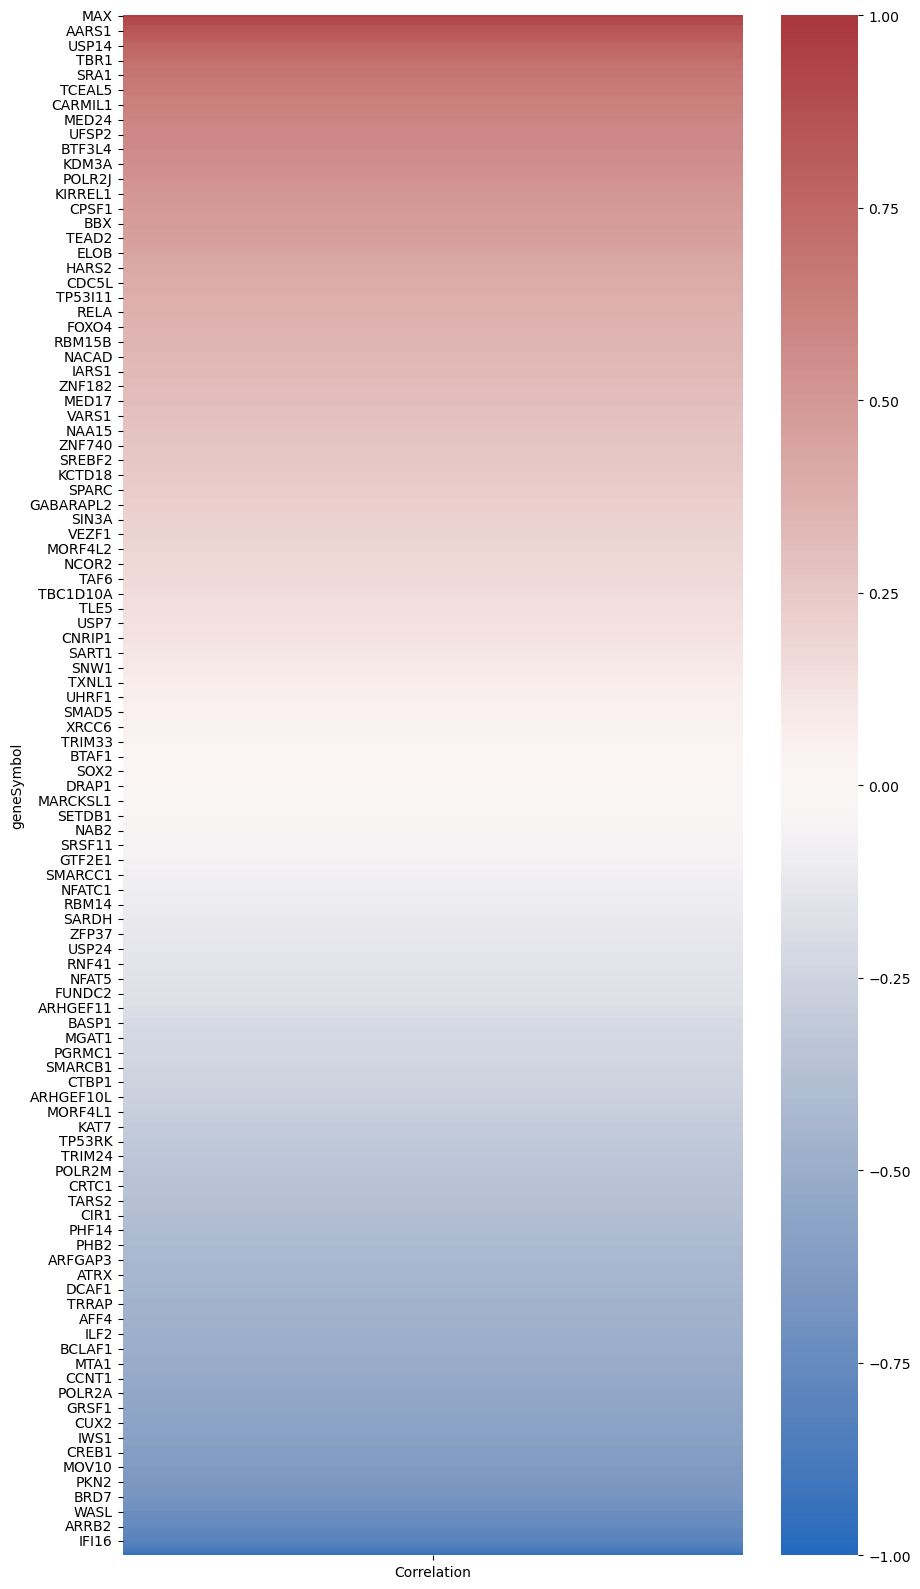

In [81]:
# Plot matched Correlation

PTQuantCorr = getQuntCorr(hmtf)

plt.figure(figsize=(10, 20))
fig3 = sns.heatmap(PTQuantCorr.sort_values(by=['Correlation'], ascending=False), vmin=-1, vmax=1, cmap='vlag')

corrfig = fig3.get_figure()
corrfig.savefig(f'{Path}/{Date}_Transcription_Factor_PTQuantCorr_Heatmap.pdf')

### Kinase

<Figure size 3000x3000 with 0 Axes>

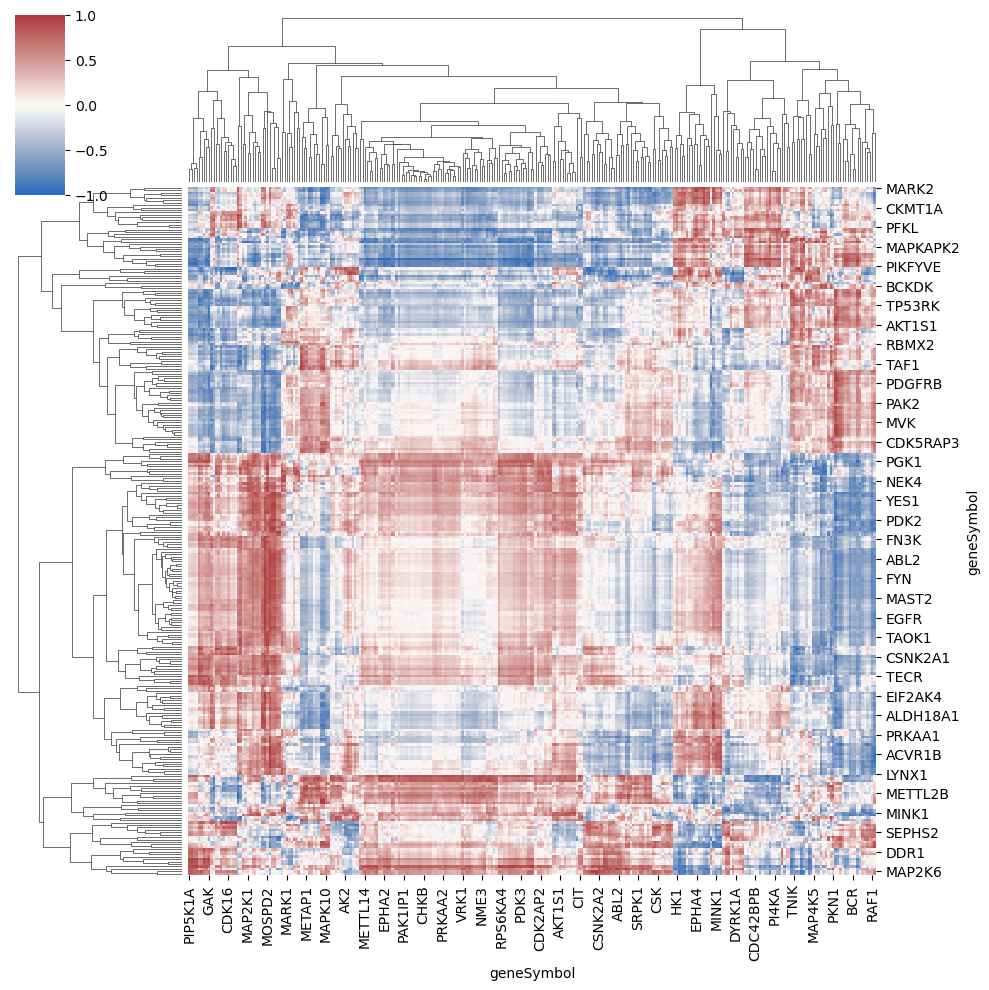

In [78]:
# Kinase
kn = pd.read_excel('kinaseHu.xlsx')

# Clean kn database
kn.rename(columns={'Entry': 'Master Protein Accessions', 'Gene Names': 'geneSymbol'}, inplace=True)
kn.drop(['Entry Name', 'Master Protein Accessions'], axis = 1, inplace=True)
kn['geneSymbol'] = kn['geneSymbol'].str.split(' ').str[0]

# Isolate Kinases
kn = kn.astype(str)
kn_list = '|'.join(list(kn.geneSymbol))
zPT_kn = zPT.loc[zPT.index.str.contains(kn_list, case=False, na=False)]
zPT_kn

# Split and Agg duplicates
np = mapped.shape[1]
zpkn = zPT_kn.iloc[:,:-np]
ztkn = zPT_kn.iloc[:,np:]
zpkn = zpkn.groupby(['geneSymbol']).agg('mean')
ztkn = ztkn.groupby(['geneSymbol']).agg('mean')

# Rename columns for correlation
zpkn.rename(columns={'131N': 'BD1', '131C': 'BD2', '132N': 'BD3', '132C': 'CTL1', '133N': 'CTL2', '133C': 'CTL3',
                  '134N': 'CTL4'}, inplace=True)
ztkn.rename(columns={'CTR1_apr': 'CTL1', 'CTR_2_feb': 'CTL2', 'CTR3_apr': 'CTL3', 'CTR_4_feb': 'CTL4',
                  'BD1_apr': 'BD1', 'BD_2_feb': 'BD2', 'BD3_apr': 'BD3'}, inplace=True)
cols = ['BD1', 'BD2', 'BD3', 'CTL1', 'CTL2', 'CTL3', 'CTL4']
ztkn = ztkn[cols]

# Make correlation dataframe
hmkn = pd.concat([zpkn.T, ztkn.T], axis=1, keys=['zp', 'zt']).corr().loc['zp', 'zt']
hmkn.to_excel(f'{Path}/{Date}_Kinase_Correlation_Heatmap_Matrix.xlsx')

# Plot Total Correlation
plt.figure(figsize=(30, 30))
knmap = sns.clustermap(hmkn,
                  vmin=-1, vmax=1,
                  annot=False,
                  cmap='vlag')

fig = knmap.fig
fig.savefig(f'{Path}/{Date}_Kinase_Clustermap.pdf')

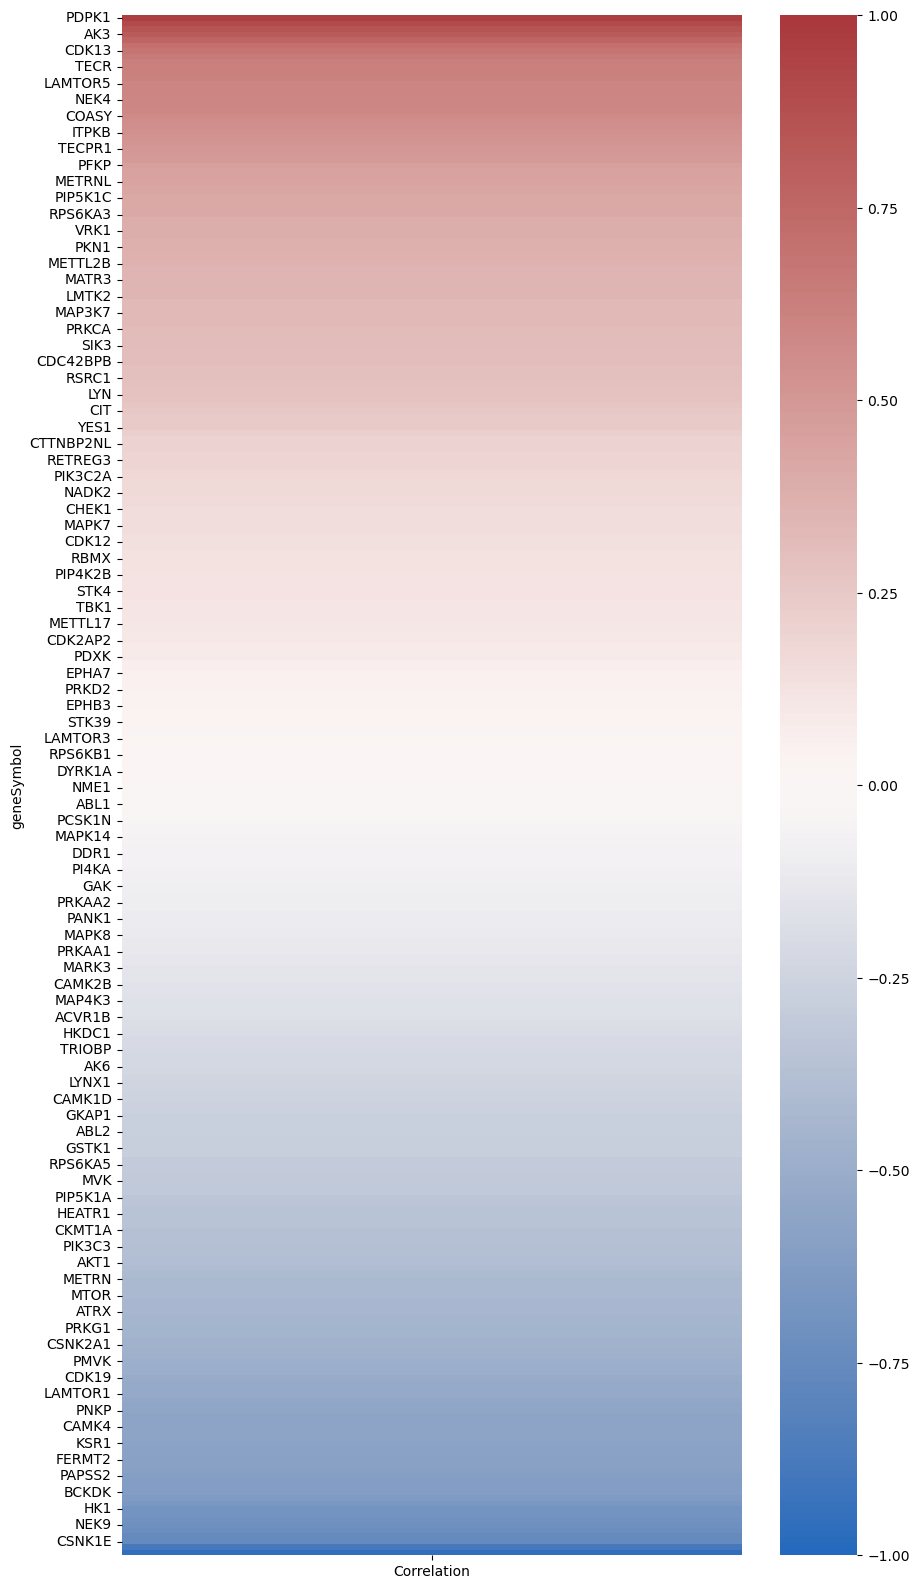

In [79]:
# Plot matched Correlation

PTQuantCorr = getQuntCorr(hmkn)

plt.figure(figsize=(10, 20))
fig3 = sns.heatmap(PTQuantCorr.sort_values(by=['Correlation'], ascending=False), vmin=-1, vmax=1, cmap='vlag')

corrfig = fig3.get_figure()
corrfig.savefig(f'{Path}/{Date}_Kinase_PTQuantCorr_Heatmap.pdf')

## BD Genes

In [75]:
# BD Genes (from Malacards)
bdg = pd.read_excel('/Users/wyssuser/Documents/BD2/BD_Genes_MalaCards.xlsx', header=None)
bdg.rename(columns={0: 'geneSymbol'}, inplace=True)

# Isolate BD genes
bdg = bdg.astype(str)
bdg_list = '|'.join(list(bdg.geneSymbol))
zPT_bdg = zPT.loc[zPT.index.str.contains(bdg_list, case=False, na=False)]
zPT_bdg

# Split and Agg duplicates
np = mapped.shape[1]
zpbdg = zPT_bdg.iloc[:,:-np]
ztbdg = zPT_bdg.iloc[:,np:]
zpbdg = zpbdg.groupby(['geneSymbol']).agg('mean')
ztbdg = ztbdg.groupby(['geneSymbol']).agg('mean')

# Rename columns for correlation
zpbdg.rename(columns={'131N': 'BD1', '131C': 'BD2', '132N': 'BD3', '132C': 'CTL1', '133N': 'CTL2', '133C': 'CTL3',
                  '134N': 'CTL4'}, inplace=True)
ztbdg.rename(columns={'CTR1_apr': 'CTL1', 'CTR_2_feb': 'CTL2', 'CTR3_apr': 'CTL3', 'CTR_4_feb': 'CTL4',
                  'BD1_apr': 'BD1', 'BD_2_feb': 'BD2', 'BD3_apr': 'BD3'}, inplace=True)
cols = ['BD1', 'BD2', 'BD3', 'CTL1', 'CTL2', 'CTL3', 'CTL4']
ztbdg = ztbdg[cols]

# Make correlation dataframe
hmbdg = pd.concat([zpbdg.T, ztbdg.T], axis=1, keys=['zp', 'zt']).corr().loc['zp', 'zt']
hmbdg.to_excel(f'{Path}/{Date}_Correlation_Heatmap_Matrix.xlsx')

# Plot
plt.figure(figsize=(30, 30))
bdgmap = sns.clustermap(hmbdg,
                  vmin=-1, vmax=1,
                  annot=False,
                  cmap='vlag')

fig = bdgmap.fig
fig.savefig(f'{Path}/{Date}_Bipolar_Disorder_Gene_Clustermap.pdf')

In [ ]:
# Plot Matched Correlation
PTQuantCorr = getQuntCorr(hmbdg)
plt.figure(figsize=(10, 20))
fig3 = sns.heatmap(PTQuantCorr.sort_values(by=['Correlation'], ascending=False), vmin=-1, vmax=1, cmap='vlag')

corrfig = fig3.get_figure()

corrfig.savefig(f'{Path}/{Date}_PTQuantCorr_Heatmap.pdf')